In [1]:
# 💤 Sleep Quality Prediction - Simple ML Project
# -------------------------------------------------
# 1️⃣ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



In [ ]:
# -------------------------------------------------
# 2️⃣ Create Synthetic Dataset (Improved & Balanced)
import numpy as np
import pandas as pd

np.random.seed(42)
n = 3000  # make it larger for better variety

age = np.random.randint(18, 70, n)
gender = np.random.choice(['Male', 'Female'], n)
screen_time = np.round(np.random.uniform(0.5, 6, n), 2)
exercise = np.random.randint(0, 120, n)
stress = np.round(np.random.uniform(1, 10, n), 2)
caffeine = np.random.choice([0, 50, 100, 150, 200, 250], n)
noise = np.random.randint(20, 60, n)

# 
sleep_hours = np.clip(
    8
    - (screen_time * 0.4)
    - (stress * 0.25)
    + (exercise / 80)
    - (caffeine / 400)
    - (noise / 80),
    3, 10
)

# Sleep quality based on more dynamic thresholds
sleep_quality = np.where(
    sleep_hours >= 7.5, 'Good',
    np.where(sleep_hours >= 6, 'Moderate', 'Poor')
)

df = pd.DataFrame({
    'Age': age,
    'Gender': gender,
    'ScreenTime': screen_time,
    'Exercise': exercise,
    'Stress': stress,
    'Caffeine': caffeine,
    'Noise': noise,
    'SleepHours': sleep_hours,
    'SleepQuality': sleep_quality
})

df.to_csv('sleep_quality.csv', index=False)
print("✅ Synthetic dataset regenerated successfully!")
print(df['SleepQuality'].value_counts())


✅ Synthetic dataset regenerated successfully!
SleepQuality
Poor        2240
Moderate     729
Good          31
Name: count, dtype: int64


In [3]:
# -------------------------------------------------
# 4️⃣ Data Understanding
print("\n--- DATA INFO ---")
print(df.info())



--- DATA INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int32  
 1   Gender        3000 non-null   object 
 2   ScreenTime    3000 non-null   float64
 3   Exercise      3000 non-null   int32  
 4   Stress        3000 non-null   float64
 5   Caffeine      3000 non-null   int64  
 6   Noise         3000 non-null   int32  
 7   SleepHours    3000 non-null   float64
 8   SleepQuality  3000 non-null   object 
dtypes: float64(3), int32(3), int64(1), object(2)
memory usage: 175.9+ KB
None


In [4]:
print("\n--- FIRST 5 ROWS ---")
print(df.head())



--- FIRST 5 ROWS ---
   Age  Gender  ScreenTime  Exercise  Stress  Caffeine  Noise  SleepHours  \
0   56    Male        3.29        54    7.56       100     51      4.5815   
1   69  Female        1.53       102    9.39        50     25      5.8780   
2   46    Male        0.92       105    3.51       100     20      7.5670   
3   32    Male        4.33        61    9.55       100     40      3.8930   
4   60  Female        2.61       111    1.57       150     23      7.2885   

  SleepQuality  
0         Poor  
1         Poor  
2         Good  
3         Poor  
4     Moderate  


In [5]:
print("\n--- DESCRIPTIVE STATS ---")
print(df.describe())


--- DESCRIPTIVE STATS ---
               Age   ScreenTime     Exercise       Stress     Caffeine  \
count  3000.000000  3000.000000  3000.000000  3000.000000  3000.000000   
mean     43.563000     3.218077    59.788333     5.458420   125.566667   
std      14.941791     1.584683    34.044861     2.556978    85.452402   
min      18.000000     0.500000     0.000000     1.000000     0.000000   
25%      31.000000     1.840000    30.000000     3.270000    50.000000   
50%      44.000000     3.180000    60.500000     5.450000   150.000000   
75%      56.000000     4.580000    88.000000     7.630000   200.000000   
max      69.000000     6.000000   119.000000    10.000000   250.000000   

             Noise   SleepHours  
count  3000.000000  3000.000000  
mean     39.281667     5.293396  
std      11.542909     1.009741  
min      20.000000     3.000000  
25%      29.000000     4.578375  
50%      39.000000     5.299750  
75%      49.000000     6.015125  
max      59.000000     8.152500  


In [6]:
print("\n--- NULL VALUES ---")
print(df.isnull().sum())



--- NULL VALUES ---
Age             0
Gender          0
ScreenTime      0
Exercise        0
Stress          0
Caffeine        0
Noise           0
SleepHours      0
SleepQuality    0
dtype: int64


In [7]:
print("\n--- VALUE COUNTS ---")
print(df['SleepQuality'].value_counts())


--- VALUE COUNTS ---
SleepQuality
Poor        2240
Moderate     729
Good          31
Name: count, dtype: int64


In [8]:

# -------------------------------------------------
# 5️⃣ Data Visualization (EDA)
sns.set(style='whitegrid', palette='viridis')



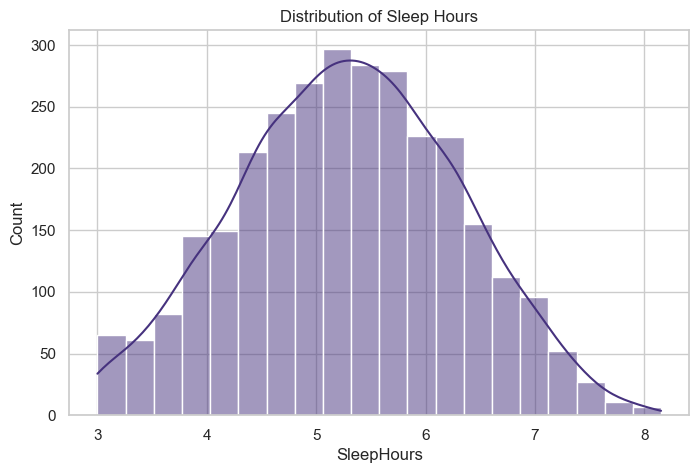

In [9]:
plt.figure(figsize=(8,5))
sns.histplot(df['SleepHours'], kde=True, bins=20)
plt.title("Distribution of Sleep Hours")
plt.savefig('plot_sleep_hours.png')
plt.show()



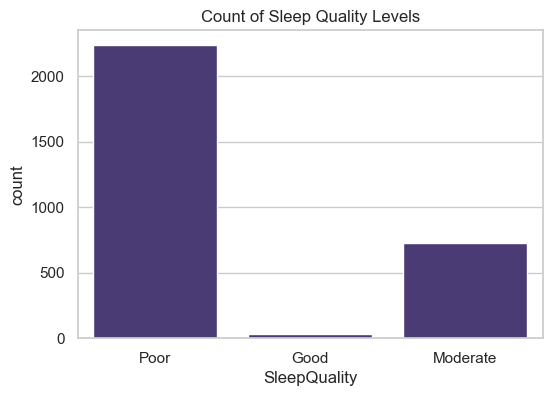

In [10]:

plt.figure(figsize=(6,4))
sns.countplot(x='SleepQuality', data=df)
plt.title("Count of Sleep Quality Levels")
plt.savefig('plot_sleep_quality_count.png')
plt.show()



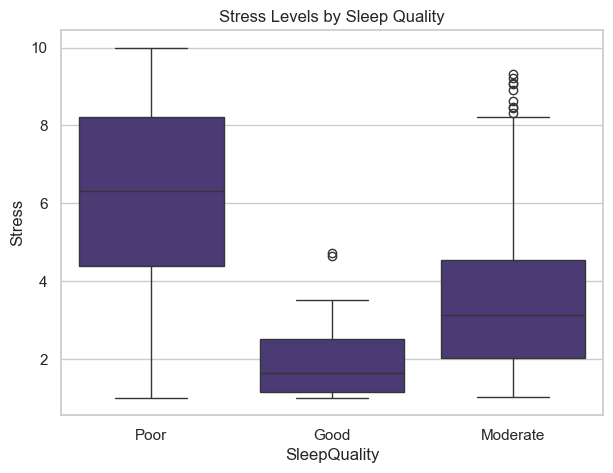

In [11]:
plt.figure(figsize=(7,5))
sns.boxplot(x='SleepQuality', y='Stress', data=df)
plt.title("Stress Levels by Sleep Quality")
plt.savefig('plot_stress_sleepquality.png')
plt.show()



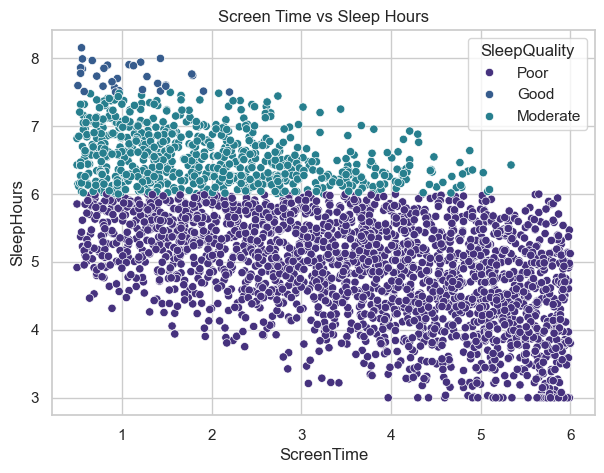

In [12]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='ScreenTime', y='SleepHours', hue='SleepQuality', data=df)
plt.title("Screen Time vs Sleep Hours")
plt.savefig('plot_screen_sleep.png')
plt.show()



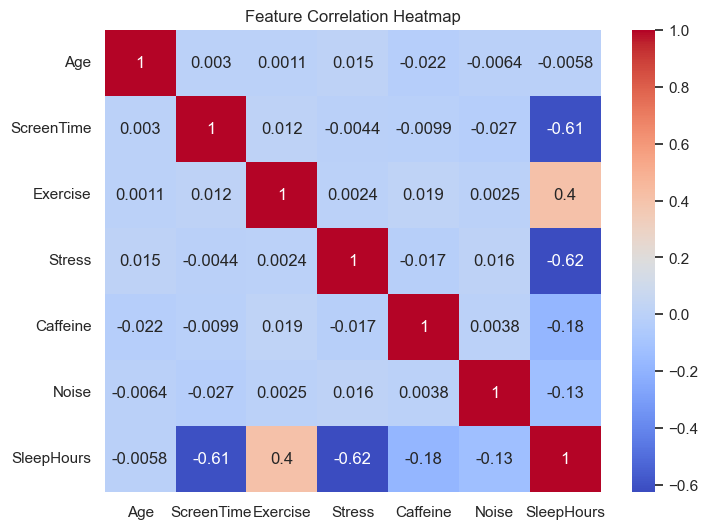

In [13]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.savefig('plot_heatmap.png')
plt.show()

In [14]:

# -------------------------------------------------
# 6️⃣ Feature Engineering
df['CaffeineCategory'] = pd.cut(df['Caffeine'], bins=[-1,50,150,300],
                                labels=['Low','Medium','High'])
df['StressLevel'] = pd.cut(df['Stress'], bins=[0,4,7,10],
                           labels=['Low','Moderate','High'])
df['Active'] = np.where(df['Exercise']>60,1,0)
df['NoiseLevel'] = np.where(df['Noise']>40,'High','Low')

print("\n--- FEATURE ENGINEERING DONE ---")
print(df[['Caffeine','CaffeineCategory','Stress','StressLevel','Exercise','Active','Noise','NoiseLevel']].head())



--- FEATURE ENGINEERING DONE ---
   Caffeine CaffeineCategory  Stress StressLevel  Exercise  Active  Noise  \
0       100           Medium    7.56        High        54       0     51   
1        50              Low    9.39        High       102       1     25   
2       100           Medium    3.51         Low       105       1     20   
3       100           Medium    9.55        High        61       1     40   
4       150           Medium    1.57         Low       111       1     23   

  NoiseLevel  
0       High  
1        Low  
2        Low  
3        Low  
4        Low  


In [15]:

# Encode categorical variables
df_encoded = df.copy()
label_enc = LabelEncoder()
df_encoded['Gender'] = label_enc.fit_transform(df_encoded['Gender'])
df_encoded['CaffeineCategory'] = label_enc.fit_transform(df_encoded['CaffeineCategory'])
df_encoded['StressLevel'] = label_enc.fit_transform(df_encoded['StressLevel'])
df_encoded['NoiseLevel'] = label_enc.fit_transform(df_encoded['NoiseLevel'])
df_encoded['SleepQuality'] = label_enc.fit_transform(df_encoded['SleepQuality'])


In [16]:

# -------------------------------------------------
# 7️⃣ Train-Test Split
X = df_encoded.drop('SleepQuality', axis=1)
y = df_encoded['SleepQuality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [17]:
# -------------------------------------------------
# 🧮 Balance the Dataset Before Training
from sklearn.utils import resample

# Check original class distribution
print("Before balancing:", df_encoded['SleepQuality'].value_counts())

# Separate classes
df_good = df_encoded[df_encoded['SleepQuality'] == 0]
df_mod = df_encoded[df_encoded['SleepQuality'] == 1]
df_poor = df_encoded[df_encoded['SleepQuality'] == 2]

# Balance by upsampling minority classes
df_balanced = pd.concat([
    resample(df_good, replace=True, n_samples=len(df_mod), random_state=42),
    df_mod,
    resample(df_poor, replace=True, n_samples=len(df_mod), random_state=42)
])

# Shuffle it up
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("After balancing:", df_balanced['SleepQuality'].value_counts())

# Define features/labels again for balanced data
X = df_balanced.drop('SleepQuality', axis=1)
y = df_balanced['SleepQuality']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Before balancing: SleepQuality
2    2240
1     729
0      31
Name: count, dtype: int64
After balancing: SleepQuality
2    729
1    729
0    729
Name: count, dtype: int64


In [18]:

# -------------------------------------------------
# 8️⃣ Model Training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(max_iter=500)
lr.fit(X_train_scaled, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [19]:

# -------------------------------------------------
# 9️⃣ Model Evaluation
print("\n--- Logistic Regression ---")
y_pred_lr = lr.predict(X_test_scaled)
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", round(accuracy_score(y_test, y_pred_lr),3))



--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       166
           1       0.98      0.98      0.98       131
           2       1.00      0.98      0.99       141

    accuracy                           0.99       438
   macro avg       0.99      0.99      0.99       438
weighted avg       0.99      0.99      0.99       438

Accuracy: 0.986


In [20]:

print("\n--- Random Forest ---")
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf),3))



--- Random Forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00       131
           2       1.00      1.00      1.00       141

    accuracy                           1.00       438
   macro avg       1.00      1.00      1.00       438
weighted avg       1.00      1.00      1.00       438

Accuracy: 1.0


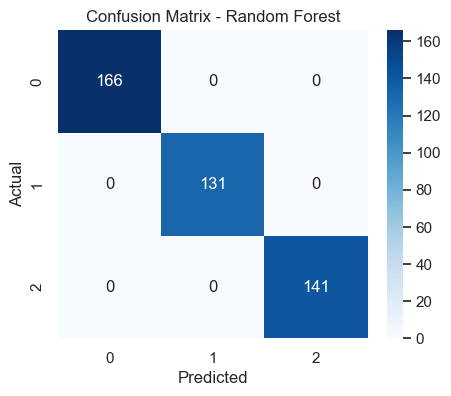

In [21]:

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('plot_confusion_rf.png')
plt.show()


In [22]:

# -------------------------------------------------
# 🔟 Predict on New Data
new_data = pd.DataFrame({
    'Age': [25],
    'Gender': [1],  # 1 for Male (encoded)
    'ScreenTime': [4.5],
    'Exercise': [30],
    'Stress': [8.2],
    'Caffeine': [150],
    'Noise': [50],
    'SleepHours': [5.6],
    'CaffeineCategory': [1],
    'StressLevel': [2],
    'Active': [0],
    'NoiseLevel': [1]
})

# Match features
new_scaled = scaler.transform(new_data)
pred = rf.predict(new_data)
pred_label = label_enc.inverse_transform(pred)
print("\n🧠 Prediction for new data:", pred_label[0])




🧠 Prediction for new data: Poor


In [23]:

# -------------------------------------------------
# 1️⃣1️⃣ Save Models
joblib.dump(lr, 'sleep_lr_model.pkl')
joblib.dump(rf, 'sleep_rf_model.pkl')
joblib.dump(scaler, 'sleep_scaler.pkl')

print("\n✅ Models saved: sleep_lr_model.pkl, sleep_rf_model.pkl, sleep_scaler.pkl")



✅ Models saved: sleep_lr_model.pkl, sleep_rf_model.pkl, sleep_scaler.pkl
